# Hybrid CNN + MLP Pion Classifier

Trained on the aligned `ALL_DATA.pkl` dataset (279,071 tracks) which contains both hit-level sequences and track-level summary statistics for each track.

Two models are trained and compared:
- **Standalone MLP**: 3 summary features only — `chi²/ndof_proton`, `track_length`, `track_score` (the "contemporary method")
- **Hybrid CNN+MLP**: CNN processes dEdX + RR sequences; MLP branch processes the 3 summary features; outputs are concatenated and classified end-to-end

In [1]:
import os, sys

# Run from project root regardless of where the notebook is opened from
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
_utils = os.path.join(os.getcwd(), 'utils')
if _utils not in sys.path:
    sys.path.insert(0, _utils)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import roc_curve, auc
from general_utils import purity, efficiency, create_confusion_matrix
from evaluation_utils import (
    plot_training_curves,
    optimise_threshold,
    plot_roc_and_purity_efficiency,
    save_results,
)

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

Using device: mps


## Data Loading

Load the aligned dataset and convert the list of per-track dicts into numpy arrays.

In [4]:
all_summary_stats = True
data_size = "all"

with open(f"prepared-data/train_{data_size}.pkl", "rb") as f:
    train = pickle.load(f)
with open("prepared-data/test.pkl", "rb") as f:
    test = pickle.load(f)

seq_train_n,  seq_test_n  = train["sequences"], test["sequences"]
mask_train,   mask_test   = train["masks"],     test["masks"]
y_train,      y_test      = train["labels"],    test["labels"]

if all_summary_stats:
    summ_train_n = train["summary"]          # (N, 4): chi2, length, score, dEdX_median
    summ_test_n  = test["summary"]
else:
    summ_train_n = train["summary"][:, [1, 3]]   # track_length, dEdX_median
    summ_test_n  = test["summary"][:, [1, 3]]

n_summary = summ_train_n.shape[1]
print(f"Train: {int(y_train.sum()):,} pions / {len(y_train):,} ({100*y_train.mean():.1f}%)")
print(f"Test:  {int(y_test.sum()):,} pions / {len(y_test):,} ({100*y_test.mean():.1f}%)")
print(f"sequences: {seq_train_n.shape}, summary: {summ_train_n.shape}")

Train: 60,979 pions / 223,256 (27.3%)
Test:  15,245 pions / 55,815 (27.3%)
sequences: (223256, 120, 2), summary: (223256, 4)


## Dataset & DataLoader

In [5]:
class HybridDataset(Dataset):
    def __init__(self, sequences, summary, masks, labels):
        # sequences: (N, 120, 2) → (N, 2, 120) for Conv1d
        self.sequences = torch.FloatTensor(sequences).permute(0, 2, 1)
        self.summary   = torch.FloatTensor(summary)
        self.masks     = torch.FloatTensor(masks)
        self.labels    = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.summary[idx], self.masks[idx], self.labels[idx]


train_dataset = HybridDataset(seq_train_n, summ_train_n, mask_train, y_train)
test_dataset  = HybridDataset(seq_test_n,  summ_test_n,  mask_test,  y_test)

y_train_int    = y_train.astype(int)
class_counts   = np.bincount(y_train_int)
sample_weights = (1.0 / class_counts)[y_train_int]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

BATCH_SIZE   = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

Train batches: 873, Test batches: 219


## Model Definitions

In [7]:
class MaskedGlobalAvgPool1d(nn.Module):
    """Average pooling that ignores zero-padded positions."""
    def forward(self, x, mask):
        # x: (B, C, L), mask: (B, L)
        mask_exp = mask.unsqueeze(1)  # (B, 1, L)
        x_masked = x * mask_exp
        lengths  = mask_exp.sum(dim=2, keepdim=True).clamp(min=1)
        return x_masked.sum(dim=2) / lengths.squeeze(2)  # (B, C)


class FocalLoss(nn.Module):
    """Down-weights easy examples so the model focuses on hard cases."""
    def __init__(self, alpha=1.0, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        bce   = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        pt    = torch.exp(-bce)
        focal = self.alpha * (1 - pt) ** self.gamma * bce
        return focal.mean()


class MLPClassifier(nn.Module):
    def __init__(self, n_features=4, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 32), nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(32, 16),         nn.BatchNorm1d(16), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(16, 1)
        )

    def forward(self, summary):
        return self.net(summary).squeeze(1)


class HybridCNNMLP(nn.Module):
    """
    CNN branch processes hit-level dEdX + RR sequences (same conv layers as PionCNN).
    MLP branch processes 3 summary statistics.
    Features are concatenated and fed to a shared classification head.
    """
    def __init__(self, in_channels=2, n_summary=4, dropout=0.3):
        super().__init__()
        # CNN branch
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=7, padding=3)
        self.bn3   = nn.BatchNorm1d(64)
        self.pool  = MaskedGlobalAvgPool1d()

        # MLP branch: 3 → 16
        self.mlp_branch = nn.Sequential(
            nn.Linear(n_summary, 16), nn.BatchNorm1d(16), nn.ReLU()
        )

        # Fusion head: concat(64, 16) = 80 → 32 → 1
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(80, 32), nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
        self.relu = nn.ReLU()

    def forward(self, sequences, summary, mask):
        # CNN branch
        x = sequences * mask.unsqueeze(1)       # zero out padding
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        cnn_feat = self.pool(x, mask)           # (B, 64)

        # MLP branch
        mlp_feat = self.mlp_branch(summary)     # (B, 16)

        # Fuse and classify
        combined = torch.cat([cnn_feat, mlp_feat], dim=1)  # (B, 80)
        return self.head(combined).squeeze(1)


print(f"StandaloneMLPClassifier params: {sum(p.numel() for p in MLPClassifier().parameters()):,}")
print(f"HybridCNNMLP params:            {sum(p.numel() for p in HybridCNNMLP().parameters()):,}")

StandaloneMLPClassifier params: 801
HybridCNNMLP params:            42,321


## Training Utilities

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, is_hybrid):
    model.train()
    total_loss, n = 0, 0
    for seq, summ, mask, y in loader:
        seq, summ, mask, y = seq.to(device), summ.to(device), mask.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(seq, summ, mask) if is_hybrid else model(summ)
        loss   = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(y)
        n += len(y)
    return total_loss / n


def evaluate_model(model, loader, criterion, is_hybrid, threshold=0.5):
    model.eval()
    total_loss, n = 0, 0
    all_probs, all_labels = [], []
    with torch.no_grad():
        for seq, summ, mask, y in loader:
            seq, summ, mask, y = seq.to(device), summ.to(device), mask.to(device), y.to(device)
            logits = model(seq, summ, mask) if is_hybrid else model(summ)
            total_loss += criterion(logits, y).item() * len(y)
            n += len(y)
            all_probs.extend(torch.sigmoid(logits).cpu().numpy())
            all_labels.extend(y.cpu().numpy().astype(int))
    all_probs  = np.array(all_probs)
    all_labels = np.array(all_labels)
    preds = (all_probs >= threshold).astype(int)
    pur   = purity(preds, all_labels, [1], [1])
    eff   = efficiency(preds, all_labels, [1], [1])
    return total_loss / n, pur, eff, all_probs, all_labels


def train_model(model, is_hybrid, label):
    criterion = FocalLoss(gamma=2.0)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    N_EPOCHS, PATIENCE = 80, 15
    best_val_loss    = float('inf')
    patience_counter = 0
    best_state       = None
    history = {'train_loss': [], 'val_loss': [], 'purity': [], 'efficiency': []}

    print(f"\n{'='*55}")
    print(f"  Training: {label}")
    print(f"{'='*55}")

    for epoch in range(N_EPOCHS):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, is_hybrid)
        val_loss, pur, eff, _, _ = evaluate_model(model, test_loader, criterion, is_hybrid)
        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['purity'].append(pur)
        history['efficiency'].append(eff)

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | "
                  f"Purity: {100*pur:.1f}% | Efficiency: {100*eff:.1f}%")

        if val_loss < best_val_loss:
            best_val_loss    = val_loss
            patience_counter = 0
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_state)
    print(f"Best val loss: {best_val_loss:.4f}")
    return model, history

## Train Hybrid CNN + MLP

CNN branch sees the full dEdX + RR hit sequences; MLP branch sees the 3 summary statistics. Both branches are trained end-to-end.

In [9]:
hybrid_model = HybridCNNMLP(n_summary=n_summary).to(device)
hybrid_model, hybrid_history = train_model(hybrid_model, is_hybrid=True, label="Hybrid CNN+MLP")


  Training: Hybrid CNN+MLP
Epoch   1 | Train: 0.1112 | Val: 0.1021 | Purity: 58.1% | Efficiency: 88.0%
Epoch  10 | Train: 0.0926 | Val: 0.1011 | Purity: 57.9% | Efficiency: 91.2%
Epoch  20 | Train: 0.0869 | Val: 0.0881 | Purity: 64.6% | Efficiency: 87.2%
Early stopping at epoch 22
Best val loss: 0.0865


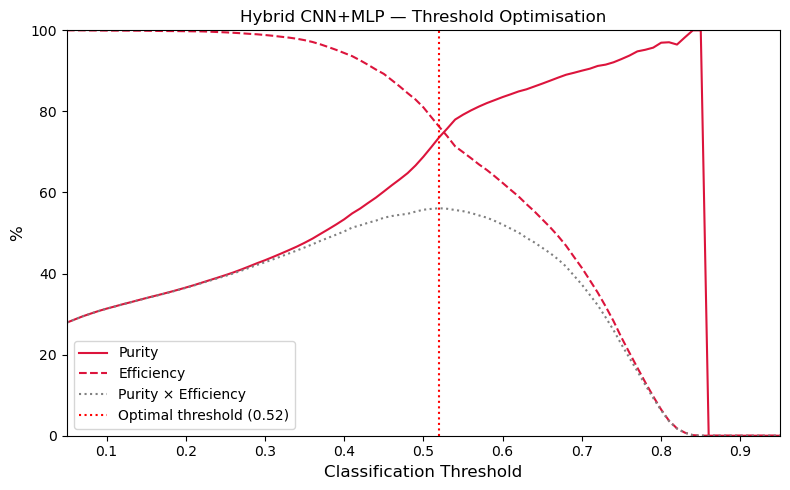

=== Hybrid CNN+MLP (threshold=0.52) ===
  AUC:        0.924
  Purity:     73.7% ± 0.4%
  Efficiency: 76.2% ± 0.3%
  Product:    56.1%
Saved to results/hybrid_cnn_mlp.pkl


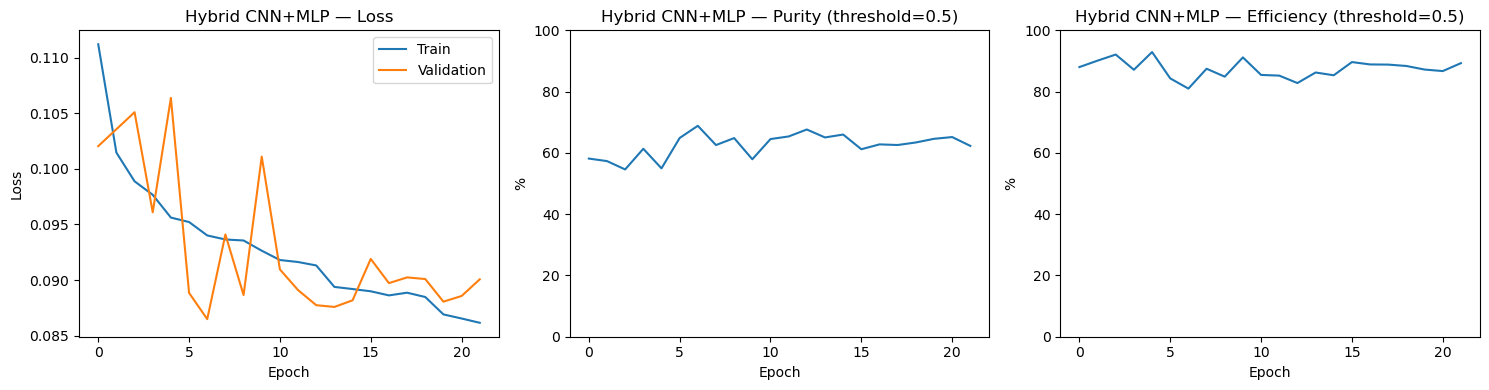

In [10]:
_, _, _, test_probs, test_labels = evaluate_model(hybrid_model, test_loader, FocalLoss(gamma=2.0), is_hybrid=True)

best_threshold = optimise_threshold(test_probs, test_labels, label='Hybrid CNN+MLP', color='crimson')
final_preds = (test_probs >= best_threshold).astype(int)

hybrid_results = save_results(
    test_probs, test_labels, best_threshold,
    model_name="Hybrid CNN+MLP (sequences + chi\u00b2/ndof_p + length + score)",
    save_path="results/hybrid_cnn_mlp.pkl",
)
plot_training_curves(hybrid_history, 'Hybrid CNN+MLP')

## Results Summary

In [21]:
print(f"{'='*65}")
print(f"{'Model':<40} {'AUC':>6}  {'Purity':>8}  {'Efficiency':>10}  {'Product':>8}")
print(f"{'='*65}")
for name, res in [("Standalone MLP", mlp_results), ("Hybrid CNN+MLP", hybrid_results)]:
    prod = res['purity'] * res['efficiency']
    print(f"{name:<40} {res['auc']:.3f}  {100*res['purity']:6.1f}%  "
          f"{100*res['efficiency']:8.1f}%  {100*prod:6.1f}%")
print(f"{'='*65}")

Model                                       AUC    Purity  Efficiency   Product
Standalone MLP                           0.878    47.7%      79.9%    38.1%
Hybrid CNN+MLP                           0.902    55.0%      78.9%    43.4%


## ROC Curves

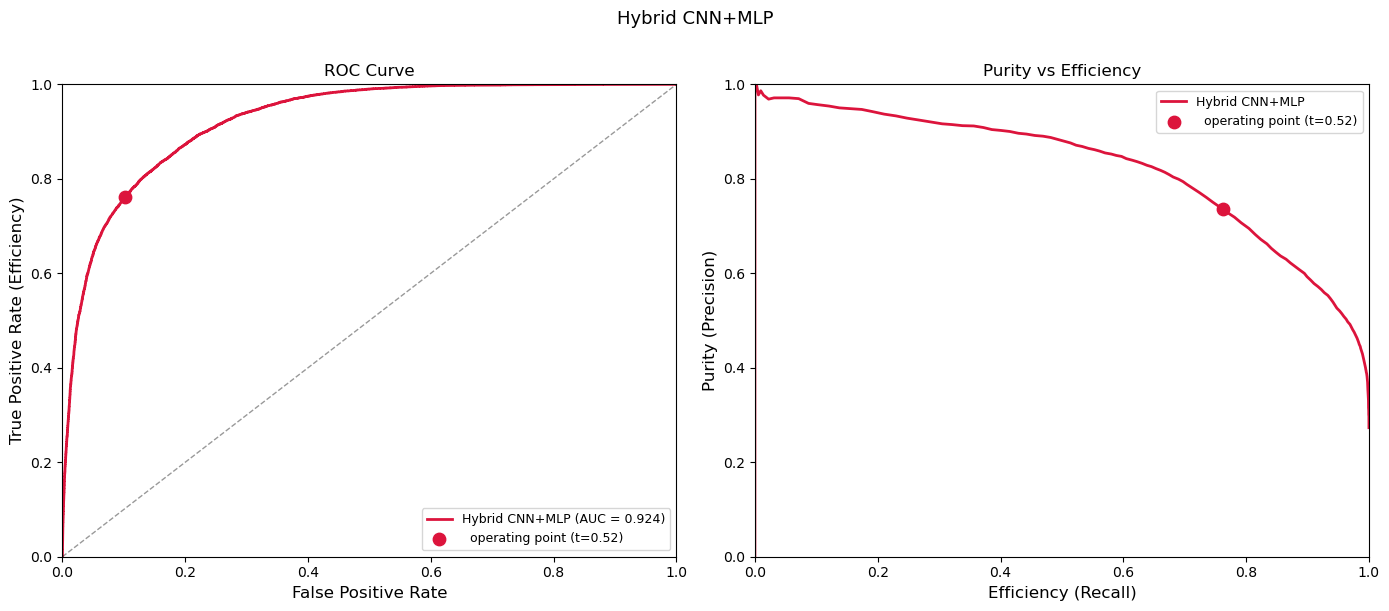

In [11]:
plot_roc_and_purity_efficiency([
    {'probs': hybrid_results['probs'], 'labels': hybrid_results['labels'],
     'threshold': hybrid_results['threshold'], 'color': 'crimson', 'label': 'Hybrid CNN+MLP'},
], title='Hybrid CNN+MLP')

In [13]:
import os, pickle
os.makedirs("saved-models", exist_ok=True)

with open("saved-models/hybrid_cnn_mlp.pkl", "wb") as f:
    pickle.dump({"model": hybrid_model, "threshold": best_threshold}, f)

print("Model saved to saved-models/hybrid_cnn_mlp.pkl")

Model saved to saved-models/hybrid_cnn_mlp.pkl
